In [ ]:

MARKET_SHARE = 0.1 # from 
AVERAGE_HOUSEHOLD_SIZE = 2.5 # US average according to ...
# recommended default baseline (actuarial starting point). Tune / replace with real data if available.
BASE_RATE = 0.01  # 1% annual claim probability per property (sensible starting point)

In [ ]:
# imports 
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
# relevant property information 
# average cost is in USD
FLORIDA = {
  "name": "Florida",
  "average_property_cost": 325000, 
  "annual_return_rate": 0.05, # arbitrary, based on market standards
}
# source for average price:
# https://www.census.gov/quickfacts/fact/table/FL/RHI725223?

WASHINGTON = {
  "name": "Washington",
  "average_property_cost": 610000, 
  "annual_return_rate": 0.05, # arbitrary, based on market standards 
}
# source for average price:
# https://ofm.wa.gov/washington-data-research/statewide-data/washington-trends/economic-trends/median-home-price


# csv files from FEMA (https://hazards.fema.gov/nri)
FLORIDA['df'] = pd.read_csv('fl_county.csv')
WASHINGTON['df'] = pd.read_csv('wa_county.csv')

In [4]:
def preprocess_location_df(location):
    """
    Transform FEMA data to estimate GLM parameters
    - frequency proxy (properties)
    - severity proxy (Expected Annual Loss (EAL) per property)
    - normalize FEMA's risk factor [0,100] -> [0,1]
    """
    df = location["df"].copy()

    # property count proxy
    df["properties"] = df["POPULATION"] / AVERAGE_HOUSEHOLD_SIZE

    # normalize risk score to [0,1]
    df["risk_scaled"] = df["RISK_SCORE"] / 100.0

    # Expected Annual Loss per property is our severity proxy
    # FEMA's EAL_VALP field is already normalized and represents loss per property
    df["severity_proxy"] = df["EAL_VALP"]

    # log-transforms for use in GLM
    df["log_properties"] = np.log(df["properties"])
    df["log_EAL"] = np.log(df["severity_proxy"])

    # save
    location["df_glm"] = df
    return df


# perform preprocessing on both state datasets
FLORIDA["df_glm"] = preprocess_location_df(FLORIDA)
WASHINGTON["df_glm"] = preprocess_location_df(WASHINGTON)

In [5]:
"""
This is the old approach from my past project, which used a Monte Carlo approach to seed properties according to 
assumed distributions with arbitrary parameters.

def seed_array(location): 
    
    location_data = []
    df = location['df']
    price_mean = location["average_property_cost"]

    for _, row in df.iterrows(): 

      # arbitrary number of properties to seed per county, linearly related to population
      pop = row.get("POPULATION", 0)
      num_county_props = int(
          max(0, (pop * MARKET_SHARE) // (AVERAGE_property_SIZE * COMPUTATIONAL_SCALE)))

      risk_score = row['RISK_SCORE'] / 100
      factor = -STEEPNESS * (risk_score - 0.7)
      risk_factor = 1 / (1 + math.exp(factor))

    # degree_of_damage reflects risk: higher risk increases mean damage fraction
      damage_loc = 0.35 + 0.5 * (risk_score)  # baseline 0.35, up to ~0.85 for high risk
      damage_scale = 0.12
      degree_of_damage = np.clip(np.random.normal(loc=damage_loc, scale=damage_scale), 0.0, 1.0)

      # derive per-policy amount
      county_build_val = row.get('BUILDVALUE', np.nan) if 'BUILDVALUE' in row.index else np.nan
      if not pd.isna(county_build_val) and county_build_val > 0 and pop > 0:
          # If BUILDVALUE looks like an aggregate county total, convert to per-property proxy
          avg_house_price = county_build_val / max(1.0, pop / AVERAGE_property_SIZE)
          base_amount = avg_house_price
      else:
          base_amount = price_mean

      # sample policy amounts with lognormal
      mu = math.log(max(1.0, base_amount)) - 0.5 * (0.2 ** 2)  # set sigma=0.2 for moderate spread
      sigma = 0.2

      for _ in range(num_county_props):
        
        amount_of_policy = np.random.normal(loc=price_mean, scale=(0.2 * price_mean))
        in_force = np.random.rand() < risk_factor

        location_data.append([amount_of_policy, in_force, risk_factor, degree_of_damage])

    return np.array(location_data)
"""

'\nThis is the old approach from my past project, which used a Monte Carlo approach to seed properties according to \nassumed distributions with arbitrary parameters.\n\ndef seed_array(location): \n    \n    location_data = []\n    df = location[\'df\']\n    price_mean = location["average_property_cost"]\n\n    for _, row in df.iterrows(): \n\n      # arbitrary number of properties to seed per county, linearly related to population\n      pop = row.get("POPULATION", 0)\n      num_county_props = int(\n          max(0, (pop * MARKET_SHARE) // (AVERAGE_property_SIZE * COMPUTATIONAL_SCALE)))\n\n      risk_score = row[\'RISK_SCORE\'] / 100\n      factor = -STEEPNESS * (risk_score - 0.7)\n      risk_factor = 1 / (1 + math.exp(factor))\n\n    # degree_of_damage reflects risk: higher risk increases mean damage fraction\n      damage_loc = 0.35 + 0.5 * (risk_score)  # baseline 0.35, up to ~0.85 for high risk\n      damage_scale = 0.12\n      degree_of_damage = np.clip(np.random.normal(loc=damag

In [ ]:


def fit_glms(location, base_rate=BASE_RATE):
    df = location["df_glm"].copy()
    df["exposure"] = df["properties"] * MARKET_SHARE

    # ensure exposure is positive
    df["exposure"] = df["exposure"].clip(lower=1e-6)

    # --- convert risk_scaled into a relative multiplier ---
    mean_risk = df["risk_scaled"].mean()
    df["risk_rel"] = df["risk_scaled"] / mean_risk

    # --- synthetic frequency target ---
    df["num_claims"] = df["exposure"] * base_rate * df["risk_rel"]

    # --- ensure severity proxy is positive (Gamma requirement) ---
    df["severity_proxy"] = df["EAL_VALP"].clip(lower=1e-6)

    # Frequency GLM
    freq_model = smf.glm(
        formula="num_claims ~ risk_scaled",
        data=df,
        family=sm.families.Poisson(),
        offset=np.log(df["exposure"])
    ).fit()

    # Severity GLM
    severity_model = smf.glm(
        formula="severity_proxy ~ risk_scaled",
        data=df,
        family=sm.families.Gamma(link=sm.families.links.log())
    ).fit()

    location["glm_frequency"] = freq_model
    location["glm_severity"] = severity_model
    location["df_glm"] = df
    return location




# apply GLM fitting to both states
FLORIDA = fit_glms(FLORIDA)
WASHINGTON = fit_glms(WASHINGTON)

# optional: inspect summaries
print("Florida Frequency GLM Summary:")
print(FLORIDA["glm_frequency"].summary())
print("\nFlorida Severity GLM Summary:")
print(FLORIDA["glm_severity"].summary())

Florida Frequency GLM Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:             num_claims   No. Observations:                   67
Model:                            GLM   Df Residuals:                       65
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -357.91
Date:                Wed, 10 Dec 2025   Deviance:                       40.798
Time:                        18:31:18   Pearson chi2:                     39.8
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.2

/Users/junomarquesoda/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/Users/junomarquesoda/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [7]:
def generate_county_level_parameters(location):
    df = location["df_glm"]

    # predicted TOTAL expected claims (lambda)
    pred_counts = location["glm_frequency"].predict(df)

    # FIX: convert model output to RATE per property
    df["rate_pred"] = pred_counts / df["exposure"]

    # FIX: scale up to total lambda properly
    df["lambda"] = df["rate_pred"] * df["exposure"]

    # severity
    df["severity_mean"] = np.exp(location["glm_severity"].predict(df))
    alpha = 1.0 / location["glm_severity"].scale
    df["severity_variance"] = df["severity_mean"]**2 / alpha

    location["df_sim"] = df
    return location


# apply to both states
FLORIDA = generate_county_level_parameters(FLORIDA)
WASHINGTON = generate_county_level_parameters(WASHINGTON)

FLORIDA["df_sim"].head()

,COUNTY,POPULATION,BUILDVALUE,AGRIVALUE,AREA,RISK_VALUE,RISK_SCORE,RISK_RATNG,RISK_SPCTL,EAL_SCORE,...,risk_scaled,severity_proxy,log_properties,log_EAL,exposure,num_claims,rate_pred,lambda,severity_mean,severity_variance
0,Alachua,277984,4.273670e+10,114608526.0,978.589107,7.607707e+07,93.827553,Relatively Moderate,50.746269,93.686165,...,0.938276,0.771449,11.619028,-0.259485,11119.36,10433.023430,0.000084,0.931116,3.752924,13.703401
1,Baker,27852,3.374423e+09,15145026.0,594.915785,5.718835e+06,46.770601,Very Low,4.477612,44.846797,...,0.467706,0.079422,9.318369,-2.532979,1114.08,521.061915,0.000472,0.525877,1.028568,1.029330
2,Bay,174869,3.231735e+10,3328101.0,1481.527798,1.907960e+08,97.486478,Relatively High,74.626866,97.183535,...,0.974865,1.632387,11.155502,0.490043,6994.76,6818.945161,0.000139,0.973412,5.953441,34.484577
3,Bradford,28233,3.560269e+09,15009945.0,303.524255,1.203216e+07,70.219535,Relatively Low,16.417910,63.200248,...,0.702195,0.093069,9.331956,-2.374417,1129.32,793.003258,0.000619,0.699077,1.211377,1.427734
4,Brevard,606067,1.055946e+11,67636257.0,1572.754393,4.493686e+08,99.363665,Relatively High,92.537313,99.380997,...,0.993637,2.686243,12.398455,0.988144,24242.68,24088.415412,0.000041,0.995851,8.004834,62.343821


In [8]:
# 4.2 Income Reallocation 
def Co(AO:int, FO:int) -> float:
  total_cost = AO * FO
  return total_cost

def Fo(risk:float) -> float:
  base_rate = 0.003
  risk_rate_coefficient = 0.001
  rate_of_policy = base_rate + risk_rate_coefficient * risk
  return rate_of_policy

def RI(properties:np.ndarray) -> int:
  return np.sum(properties[:, 0])

def RIa(RI:int) -> int: 
  return RI * 0.12

def RIa_prime(RI:int) -> int: 
  return RIa(RI)

def OSh(properties:np.ndarray, risk_threshold:int) -> np.ndarray:
  return properties[properties[:, 1] >= risk_threshold]

def RIb(OSh):
  return np.sum(OSh[:, 0])

# works individually for each property 
def Eo(prop: np.ndarray, payout_amount: float) -> float:
    retained_fraction = 0.2 * prop[0]      # 20% retained
    return retained_fraction - (payout_amount if prop[1] else 0)

def POh_prime(prop:np.ndarray, location: dict) -> float:
  return Po(prop, location)

def RIc(RI_value: float, RIa_value: float, RIb_value: float) -> float:
    return RI_value - RIa_value - RIb_value

def RIc_prime(RIc_value: float, location: dict) -> float:
    return RIc_value * (1 + location["annual_return_rate"])

def RIb_prime(OSh: np.ndarray, location: dict) -> float:
    value = 0.0
    for prop in OSh:
        payout = POh_prime(prop, location)
        value += Eo(prop, payout)
    return value

# FIX: Revenue R must use all terms (RIb_prime is a cost or offset depending on model)
def R(RIa_prime_val: float, RIb_prime_val: float, RIc_prime_val: float) -> float:
    return RIa_prime_val + RIc_prime_val - RIb_prime_val

# only need the high-risk properties
def Po(prop:np.ndarray, location:dict) -> int:
  return prop[0] * prop[3] # claim = property_value * damage_degree

def C(properties:np.ndarray, location:dict) -> int:
  cost_for_insurance_company = 0
  for prop in properties:
    # only add the claim if in force 
    cost_for_insurance_company += Po(prop, location) if prop[1] else 0
  return cost_for_insurance_company

def P(R:int, C:int) -> int:
  return R - C

In [9]:
def get_profit(location):
  properties = seed_array(location)
  RI_value = RI(properties)
  RIa_value = RIa(RI_value)
  RIb_value = RIb(OSh(properties, risk_threshold=0.8))
  RIc_value = RIc(RI_value, RIa_value, RIb_value)
  RIc_prime_value = RIc_prime(RIc_value, location)
  R_value = R(RIa_value, RIb_value, RIc_prime_value)
  C_value = C(properties, location)

  return R_value, C_value, P(R_value, C_value)

def run_simulation(location, num_trials:100):
    
    data = []

    for _ in range(num_trials):
        # risk, cost, profit
        data.append(list(get_profit(location)))
    
    return np.array(data)

In [10]:
profit_color = 'green'
return_color = 'blue'
cost_color = 'red'
break_even_color = 'black'

def generate_comparison_plot(location1, location2, num_trials=100):

    data_location1 = location1['model_data']
    data_location2 = location2['model_data']

    fig, axes = plt.subplots(1, 2, sharey=True, figsize=(14, 6))

    axes[0].plot(range(num_trials), data_location1[:, 0], label="Return", color=return_color)
    axes[0].plot(range(num_trials), data_location1[:, 1], label="Cost", color=cost_color)
    axes[0].plot(range(num_trials), data_location1[:, 2], label="Profit", color=profit_color)
    axes[0].axhline(0, color=break_even_color, linestyle="--", label="Break-even Line")
    axes[0].set_title(location1['name'])
    axes[0].set_xlabel("Trial")
    axes[0].set_ylabel("Amount")
    

    axes[1].plot(range(num_trials), data_location2[:, 0], label="Return", color=return_color)
    axes[1].plot(range(num_trials), data_location2[:, 1], label="Cost", color=cost_color)
    axes[1].plot(range(num_trials), data_location2[:, 2], label="Profit", color=profit_color)
    axes[1].axhline(color=break_even_color, linestyle="--", label="Break-even Line")
    axes[1].set_title(location2['name'])
    axes[1].set_xlabel("Value")
    axes[1].set_ylabel("Amount")
    
    axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))

    fig.tight_layout()
    plt.show()


In [11]:
FLORIDA['model_data'] = run_simulation(FLORIDA, num_trials=NUM_TRIALS)
WASHINGTON['model_data'] = run_simulation(WASHINGTON, num_trials=NUM_TRIALS)

NameError: name 'seed_array' is not defined

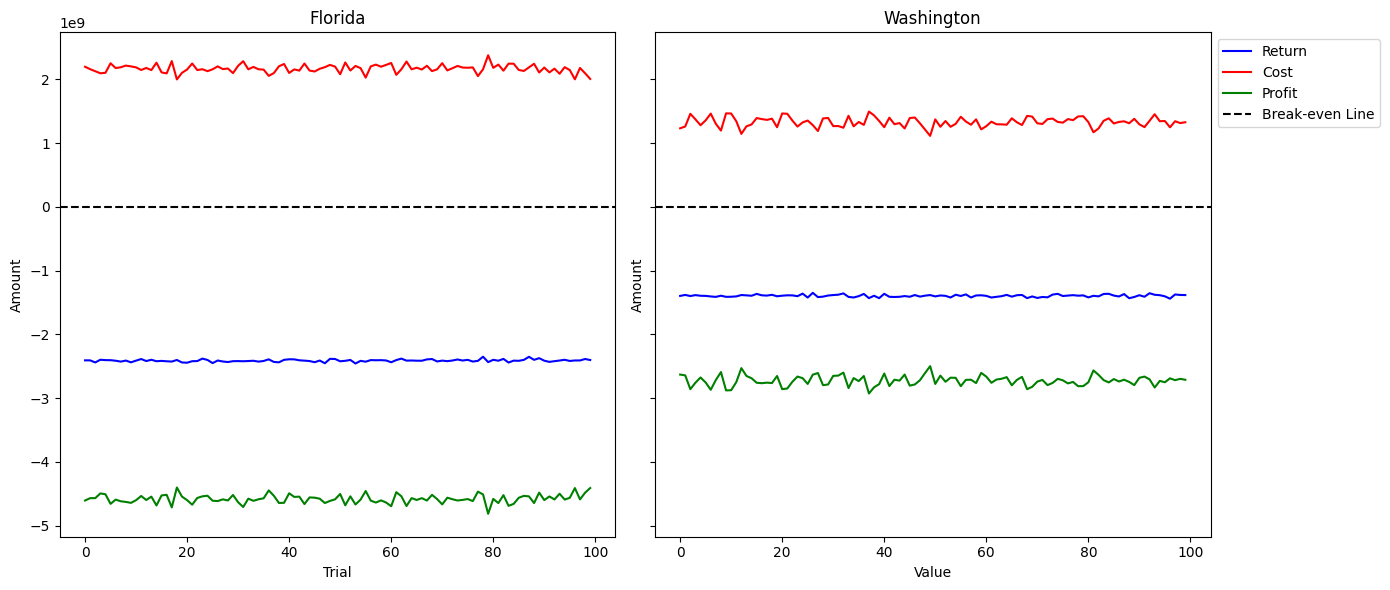

In [ ]:
generate_comparison_plot(FLORIDA, WASHINGTON, num_trials=NUM_TRIALS)